<a id='top'></a>

# Data Engineering of Opta City Analytics Data
##### Notebook to engineer the aggregated match-by-match performance Excel data and F24 Event data available from Opta as part of the [#mcfcanalytics](https://web.archive.org/web/20120821021930/http://www.mcfc.co.uk/Home/The%20Club/MCFC%20Analytics) initiative

### By [Edd Webster](https://www.twitter.com/eddwebster)
Notebook first written: 02/12/2020<br>
Notebook last updated: 07/12/2020

![title](../../img/opta-mcfcanalytics.png)

Click [here](#section5) to jump straight to the Exploratory Data Analysis section and skip the [Task Brief](#section2), [Data Sources](#section3), and [Data Engineering](#section4) sections. Or click [here](#section6) to jump straight to the Conclusion.

___

<a id='sectionintro'></a>

## <a id='import_libraries'>Introduction</a>
This notebook engineers the aggregated performance Excel data available from Opta as part of the [#mcfcanalytics](https://web.archive.org/web/20120821021930/http://www.mcfc.co.uk/Home/The%20Club/MCFC%20Analytics) initiative for the 11/12 Premier League season using [pandas](http://pandas.pydata.org/) for data manipulation through DataFrames.

For more information about this notebook and the author, I'm available through all the following channels:
*    [eddwebster.com](https://www.eddwebster.com/);
*    edd.j.webster@gmail.com;
*    [@eddwebster](https://www.twitter.com/eddwebster);
*    [linkedin.com/in/eddwebster](https://www.linkedin.com/in/eddwebster/);
*    [github/eddwebster](https://github.com/eddwebster/);
*    [public.tableau.com/profile/edd.webster](https://public.tableau.com/profile/edd.webster);
*    [kaggle.com/eddwebster](https://www.kaggle.com/eddwebster); and
*    [hackerrank.com/eddwebster](https://www.hackerrank.com/eddwebster).

![title](../../img/fifa21eddwebsterbanner.png)

The accompanying GitHub repository for this notebook can be found [here](https://github.com/eddwebster/fifa-league) and a static version of this notebook can be found [here](https://nbviewer.jupyter.org/github/eddwebster/football_analytics/blob/master/notebooks/B%29%20Data%20Engineering/Opta%20%23mcfcanalytics%20PL%202011-2012.ipynb).

___

<a id='sectioncontents'></a>

## <a id='notebook_contents'>Notebook Contents</a>
1.    [Notebook Dependencies](#section1)<br>
2.    [Project Brief](#section2)<br>
3.    [Data Sources](#section3)<br>
      1.    [Introduction](#section3.1)<br>
      2.    [Data Dictionary](#section3.2)<br>
      3.    [Creating the DataFrame](#section3.3)<br>
      4.    [Initial Data Handling](#section3.4)<br>
      5.    [Export the Raw DataFrame](#section3.5)<br>         
4.    [Data Engineering](#section4)<br>
      1.    [Introduction](#section4.1)<br>
      2.    [Columns of Interest](#section4.2)<br>
      3.    [String Cleaning](#section4.3)<br>
      4.    [Converting Data Types](#section4.4)<br>
      5.    [Export the Engineered DataFrame](#section4.5)<br>
5.    [Exploratory Data Analysis (EDA)](#section5)<br>
      1.    [...](#section5.1)<br>
      2.    [...](#section5.2)<br>
      3.    [...](#section5.3)<br>
6.    [Summary](#section6)<br>
7.    [Next Steps](#section7)<br>
8.    [Bibliography](#section8)<br>

___

<a id='section1'></a>

## <a id='#section1'>1. Notebook Dependencies</a>

This notebook was written using [Python 3](https://docs.python.org/3.7/) and requires the following libraries:
*    [`Jupyter notebooks`](https://jupyter.org/) for this notebook environment with which this project is presented;
*    [`NumPy`](http://www.numpy.org/) for multidimensional array computing;
*    [`pandas`](http://pandas.pydata.org/) for data analysis and manipulation; and
*    [`matplotlib`](https://matplotlib.org/contents.html?v=20200411155018) for data visualisations;

All packages used for this notebook except for BeautifulSoup can be obtained by downloading and installing the [Conda](https://anaconda.org/anaconda/conda) distribution, available on all platforms (Windows, Linux and Mac OSX). Step-by-step guides on how to install Anaconda can be found for Windows [here](https://medium.com/@GalarnykMichael/install-python-on-windows-anaconda-c63c7c3d1444) and Mac [here](https://medium.com/@GalarnykMichael/install-python-on-mac-anaconda-ccd9f2014072), as well as in the Anaconda documentation itself [here](https://docs.anaconda.com/anaconda/install/).

### Import Libraries and Modules

In [142]:
# Python ≥3.5 (ideally)
import platform
import sys, getopt
assert sys.version_info >= (3, 5)
import csv
import xml.etree.ElementTree as et

# Import Dependencies
%matplotlib inline

# Math Operations
import numpy as np
from math import pi

# Datetime
import datetime
from datetime import date
#from datetime import datetime as dt
import time

# Data Preprocessing
import pandas as pd
import os
import re
import random
from io import BytesIO
from pathlib import Path

# Reading directories
import glob
import os

# Working with JSON
import json
from pandas.io.json import json_normalize
from ast import literal_eval

# Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import missingno as msno
from tabulate import tabulate

# Display in Jupyter
from IPython.display import Image, Video, YouTubeVideo
from IPython.core.display import HTML

# Ignore Warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

print('Setup Complete')

Setup Complete


In [4]:
# Python / module versions used here for reference
print('Python: {}'.format(platform.python_version()))
print('NumPy: {}'.format(np.__version__))
print('pandas: {}'.format(pd.__version__))
print('matplotlib: {}'.format(mpl.__version__))
print('Seaborn: {}'.format(sns.__version__))

Python: 3.7.6
NumPy: 1.18.1
pandas: 1.0.1
matplotlib: 3.1.3
Seaborn: 0.10.0


### Defined Variables

In [5]:
# Define today's date
today = datetime.datetime.now().strftime('%d/%m/%Y').replace('/', '')

### Defined Filepaths

In [144]:
# Set up initial paths to subfolders
base_dir = os.path.join('..', '..', )
data_dir = os.path.join(base_dir, 'data')
data_dir_opta = os.path.join(base_dir, 'data', 'opta')
data_dir_fixtures = os.path.join(base_dir, 'data', 'fixtures')
img_dir = os.path.join(base_dir, 'img')
fig_dir = os.path.join(base_dir, 'img', 'fig')
video_dir = os.path.join(base_dir, 'video')

### Notebook Settings

In [7]:
pd.set_option('display.max_columns', None)

---

<a id='section2'></a>

## <a id='#section2'>2. Project Brief</a>
This Jupyter notebook explores how to parse publicly available Event data from [Opta](https://www.optasports.com/) using [pandas](http://pandas.pydata.org/) for data manipulation through DataFrames.

In this analysis, we're looking specifically at [Premier League](https://www.premierleague.com/) for the 11/12 season.

The engineered event data roduced in this notebook is exported to CSV. This data can be further analysed in Python, joined to other datasets, or explored using Tableau, PowerBI, Microsoft Excel.

---

<a id='section3'></a>

## <a id='#section3'>3. Data Sources</a>

### <a id='#section3.1'>3.1. Introduction</a>
[Opta](https://www.optasports.com/) are a football analytics and data company.

The data needs to be imported as a DataFrame in the Data Sources section [Section 3](#section3) and cleaned in the Data Engineering section [Section 4](#section4).

The [Opta](https://www.optasports.com/) data made available for the  [#mcfcanalytics](https://web.archive.org/web/20120821021930/http://www.mcfc.co.uk/Home/The%20Club/MCFC%20Analytics) initiative is available in two sources:
- Match-by-Match aggregated performance data for all players during the 11/12 season
- Opta F24 Event data for Manchester City vs. Bolton Wanders on 21/08/2011 [[link](https://www.bbc.co.uk/sport/football/14520274)]

The data import is divided into these two sections.

We'll be using the [pandas](http://pandas.pydata.org/) library to import our data to this workbook as a DataFrame.

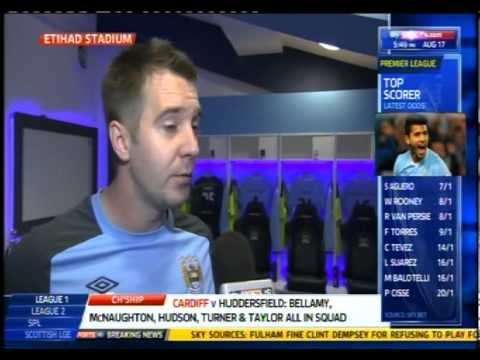

In [150]:
# #mcfcanalytics - Head of Performance Analysis explains concept.
YouTubeVideo('ikm52r7RlKc')

### <a id='#section3.2'>3.2. Match-by-Match Data</a>

#### <a id='#section3.2.1'>3.2.1. Data Dictionary</a>
The [Opta](https://www.optasports.com/) dataset has one hundred and fourteen features (columns) with the following definitions and data types:

| Feature     | Data type    |
|------|-----|
| `id`    | `object`
| `index`    | `object`
| `period`    | `object`
| `timestamp`    | `object`
| `minute`    | `object`
| `second`    | `object`
| `possession`    | `object`
| `duration`    | `object`
| `type.id`    | `object`
| `type.name`    | `object`
| `possession_team.id`    | `object`


For a full list of definitions, see the official documentation [[link](https://github.com/eddwebster/football_analytics/blob/master/documentation/opta/Event%20Definitions%20-%20MCFC%20analytics.pdf)].

#### <a id='#section3.2.2'>3.2.2. Import Data</a>

In [9]:
# Import XLS file of aggregated performance data as a pandas DataFrame
df_opta_mbm_raw = pd.read_excel(data_dir_opta + '/raw/match_by_match/' + 'opta_match_by_match_pl_1112.xls')

#### <a id='#section3.2.3'>3.2.3. Initial Data Handling</a>
Let's quality of the dataset by looking first and last rows in pandas using the [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) methods.

In [110]:
# Display the first 5 rows of the raw DataFrame, df_opta_mbm_raw
df_opta_mbm_raw.head()

,Date,Player ID,Player Surname,Player Forename,Team,Team Id,Opposition,Opposition id,Venue,Position Id,Appearances,Time Played,Starts,Substitute On,Substitute Off,Goals,First Goal,Winning Goal,Shots On Target inc goals,Shots Off Target inc woodwork,Blocked Shots,Penalties Taken,Penalty Goals,Penalties Saved,Penalties Off Target,Penalties Not Scored,Direct Free-kick Goals,Direct Free-kick On Target,Direct Free-kick Off Target,Blocked Direct Free-kick,Goals from Inside Box,Shots On from Inside Box,Shots Off from Inside Box,Blocked Shots from Inside Box,Goals from Outside Box,Shots On Target Outside Box,Shots Off Target Outside Box,Blocked Shots Outside Box,Headed Goals,Headed Shots On Target,Headed Shots Off Target,Headed Blocked Shots,Left Foot Goals,Left Foot Shots On Target,Left Foot Shots Off Target,Left Foot Blocked Shots,Right Foot Goals,Right Foot Shots On Target,Right Foot Shots Off Target,Right Foot Blocked Shots,Other Goals,Other Shots On Target,Other Shots Off Target,Other Blocked Shots,Shots Cleared off Line,Shots Cleared off Line Inside Area,Shots Cleared off Line Outside Area,Goals Open Play,Goals from Corners,Goals from Throws,Goals from Direct Free Kick,Goals from Set Play,Goals from penalties,Attempts Open Play on target,Attempts from Corners on target,Attempts from Throws on target,Attempts from Direct Free Kick on target,Attempts from Set Play on target,Attempts from Penalties on target,Attempts Open Play off target,Attempts from Corners off target,Attempts from Throws off target,Attempts from Direct Free Kick off target,Attempts from Set Play off target,Attempts from Penalties off target,Goals as a substitute,Total Successful Passes All,Total Unsuccessful Passes All,Assists,Key Passes,Total Successful Passes Excl Crosses Corners,Total Unsuccessful Passes Excl Crosses Corners,Successful Passes Own Half,Unsuccessful Passes Own Half,Successful Passes Opposition Half,Unsuccessful Passes Opposition Half,Successful Passes Defensive third,Unsuccessful Passes Defensive third,Successful Passes Middle third,Unsuccessful Passes Middle third,Successful Passes Final third,Unsuccessful Passes Final third,Successful Short Passes,Unsuccessful Short Passes,Successful Long Passes,Unsuccessful Long Passes,Successful Flick-Ons,Unsuccessful Flick-Ons,Successful Crosses Corners,Unsuccessful Crosses Corners,Corners Taken incl short corners,Corners Conceded,Successful Corners into Box,Unsuccessful Corners into Box,Short Corners,Throw Ins to Own Player,Throw Ins to Opposition Player,Successful Dribbles,Unsuccessful Dribbles,Successful Crosses Corners Left,Unsuccessful Crosses Corners Left,Successful Crosses Left,Unsuccessful Crosses Left,Successful Corners Left,Unsuccessful Corners Left,Successful Crosses Corners Right,Unsuccessful Crosses Corners Right,Successful Crosses Right,Unsuccessful Crosses Right,Successful Corners Right,Unsuccessful Corners Right,Successful Long Balls,Unsuccessful Long Balls,Successful Lay-Offs,Unsuccessful Lay-Offs,Through Ball,Successful Crosses Corners in the air,Unsuccessful Crosses Corners in the air,Successful crosses in the air,Unsuccessful crosses in the air,Successful open play crosses,Unsuccessful open play crosses,Touches,Goal Assist Corner,Goal Assist Free Kick,Goal Assist Throw In,Goal Assist Goal Kick,Goal Assist Set Piece,Key Corner,Key Free Kick,Key Throw In,Key Goal Kick,Key Set Pieces,Duels won,Duels lost,Aerial Duels won,Aerial Duels lost,Ground Duels won,Ground Duels lost,Tackles Won,Tackles Lost,Last Man Tackle,Total Clearances,Headed Clearances,Other Clearances,Clearances Off the Line,Blocks,Interceptions,Recoveries,Total Fouls Conceded,Fouls Conceded exc handballs pens,Total Fouls Won,Fouls Won in Danger Area inc pens,Fouls Won not in danger area,Foul Won Penalty,Handballs Conceded,Penalties Conceded,Offsides,Yellow Cards,Red Cards,Goals Conceded,Goals Conceded Inside Box,Goals Conceded Outside Box,Saves Made,Saves Made from Inside Box,Saves Made from Outside Box,Saves from Penalty,Cat

In [111]:
# Display the last 5 rows of the raw DataFrame, df_opta_mbm_raw
df_opta_mbm_raw.tail()

,Date,Player ID,Player Surname,Player Forename,Team,Team Id,Opposition,Opposition id,Venue,Position Id,Appearances,Time Played,Starts,Substitute On,Substitute Off,Goals,First Goal,Winning Goal,Shots On Target inc goals,Shots Off Target inc woodwork,Blocked Shots,Penalties Taken,Penalty Goals,Penalties Saved,Penalties Off Target,Penalties Not Scored,Direct Free-kick Goals,Direct Free-kick On Target,Direct Free-kick Off Target,Blocked Direct Free-kick,Goals from Inside Box,Shots On from Inside Box,Shots Off from Inside Box,Blocked Shots from Inside Box,Goals from Outside Box,Shots On Target Outside Box,Shots Off Target Outside Box,Blocked Shots Outside Box,Headed Goals,Headed Shots On Target,Headed Shots Off Target,Headed Blocked Shots,Left Foot Goals,Left Foot Shots On Target,Left Foot Shots Off Target,Left Foot Blocked Shots,Right Foot Goals,Right Foot Shots On Target,Right Foot Shots Off Target,Right Foot Blocked Shots,Other Goals,Other Shots On Target,Other Shots Off Target,Other Blocked Shots,Shots Cleared off Line,Shots Cleared off Line Inside Area,Shots Cleared off Line Outside Area,Goals Open Play,Goals from Corners,Goals from Throws,Goals from Direct Free Kick,Goals from Set Play,Goals from penalties,Attempts Open Play on target,Attempts from Corners on target,Attempts from Throws on target,Attempts from Direct Free Kick on target,Attempts from Set Play on target,Attempts from Penalties on target,Attempts Open Play off target,Attempts from Corners off target,Attempts from Throws off target,Attempts from Direct Free Kick off target,Attempts from Set Play off target,Attempts from Penalties off target,Goals as a substitute,Total Successful Passes All,Total Unsuccessful Passes All,Assists,Key Passes,Total Successful Passes Excl Crosses Corners,Total Unsuccessful Passes Excl Crosses Corners,Successful Passes Own Half,Unsuccessful Passes Own Half,Successful Passes Opposition Half,Unsuccessful Passes Opposition Half,Successful Passes Defensive third,Unsuccessful Passes Defensive third,Successful Passes Middle third,Unsuccessful Passes Middle third,Successful Passes Final third,Unsuccessful Passes Final third,Successful Short Passes,Unsuccessful Short Passes,Successful Long Passes,Unsuccessful Long Passes,Successful Flick-Ons,Unsuccessful Flick-Ons,Successful Crosses Corners,Unsuccessful Crosses Corners,Corners Taken incl short corners,Corners Conceded,Successful Corners into Box,Unsuccessful Corners into Box,Short Corners,Throw Ins to Own Player,Throw Ins to Opposition Player,Successful Dribbles,Unsuccessful Dribbles,Successful Crosses Corners Left,Unsuccessful Crosses Corners Left,Successful Crosses Left,Unsuccessful Crosses Left,Successful Corners Left,Unsuccessful Corners Left,Successful Crosses Corners Right,Unsuccessful Crosses Corners Right,Successful Crosses Right,Unsuccessful Crosses Right,Successful Corners Right,Unsuccessful Corners Right,Successful Long Balls,Unsuccessful Long Balls,Successful Lay-Offs,Unsuccessful Lay-Offs,Through Ball,Successful Crosses Corners in the air,Unsuccessful Crosses Corners in the air,Successful crosses in the air,Unsuccessful crosses in the air,Successful open play crosses,Unsuccessful open play crosses,Touches,Goal Assist Corner,Goal Assist Free Kick,Goal Assist Throw In,Goal Assist Goal Kick,Goal Assist Set Piece,Key Corner,Key Free Kick,Key Throw In,Key Goal Kick,Key Set Pieces,Duels won,Duels lost,Aerial Duels won,Aerial Duels lost,Ground Duels won,Ground Duels lost,Tackles Won,Tackles Lost,Last Man Tackle,Total Clearances,Headed Clearances,Other Clearances,Clearances Off the Line,Blocks,Interceptions,Recoveries,Total Fouls Conceded,Fouls Conceded exc handballs pens,Total Fouls Won,Fouls Won in Danger Area inc pens,Fouls Won not in danger area,Foul Won Penalty,Handballs Conceded,Penalties Conceded,Offsides,Yellow Cards,Red Cards,Goals Conceded,Goals Conceded Inside Box,Goals Conceded Outside Box,Saves Made,Saves Made from Inside Box,Saves Made from Outside Box,Saves from Penalty,Cat

In [112]:
# Print the shape of the raw DataFrame, df_opta_mbm_raw
print(df_opta_mbm_raw.shape)

(10369, 210)


In [113]:
# Print the column names of the raw DataFrame, df_opta_mbm_raw
print(df_opta_mbm_raw.columns)

Index(['Date', 'Player ID', 'Player Surname', 'Player Forename', 'Team',
       'Team Id', 'Opposition', 'Opposition id', 'Venue', 'Position Id',
       ...
       'Pass Left', 'Pass Right', 'Unsuccessful Ball Touch',
       'Successful Ball Touch', 'Take-Ons Overrun', 'CompId', 'SeasId',
       'Touches open play final third', 'Touches open play opp box',
       'Touches open play opp six yards'],
      dtype='object', length=210)


The dataset has two hundred and ten features (columns). Full details of these attributes can be found in the [Data Dictionary](section3.3.1).

In [114]:
# Data types of the features of the raw DataFrame, df_opta_mbm_raw
df_opta_mbm_raw.dtypes

Date                               object
Player ID                           int64
Player Surname                     object
Player Forename                    object
Team                               object
                                    ...  
CompId                              int64
SeasId                              int64
Touches open play final third       int64
Touches open play opp box           int64
Touches open play opp six yards     int64
Length: 210, dtype: object

All six of the columns have the object data type. Full details of these attributes and their data types can be found in the [Data Dictionary](section3.3.1).

In [115]:
# Info for the raw DataFrame, df_opta_mbm_raw
df_opta_mbm_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10369 entries, 0 to 10368
Columns: 210 entries, Date to Touches open play opp six yards
dtypes: int64(204), object(6)
memory usage: 16.6+ MB


In [116]:
# Description of the raw DataFrame, df_sb_raw, showing some summary statistics for each numberical column in the DataFrame
df_opta_mbm_raw.describe()

,Player ID,Team Id,Opposition id,Position Id,Appearances,Time Played,Starts,Substitute On,Substitute Off,Goals,First Goal,Winning Goal,Shots On Target inc goals,Shots Off Target inc woodwork,Blocked Shots,Penalties Taken,Penalty Goals,Penalties Saved,Penalties Off Target,Penalties Not Scored,Direct Free-kick Goals,Direct Free-kick On Target,Direct Free-kick Off Target,Blocked Direct Free-kick,Goals from Inside Box,Shots On from Inside Box,Shots Off from Inside Box,Blocked Shots from Inside Box,Goals from Outside Box,Shots On Target Outside Box,Shots Off Target Outside Box,Blocked Shots Outside Box,Headed Goals,Headed Shots On Target,Headed Shots Off Target,Headed Blocked Shots,Left Foot Goals,Left Foot Shots On Target,Left Foot Shots Off Target,Left Foot Blocked Shots,Right Foot Goals,Right Foot Shots On Target,Right Foot Shots Off Target,Right Foot Blocked Shots,Other Goals,Other Shots On Target,Other Shots Off Target,Other Blocked Shots,Shots Cleared off Line,Shots Cleared off Line Inside Area,Shots Cleared off Line Outside Area,Goals Open Play,Goals from Corners,Goals from Throws,Goals from Direct Free Kick,Goals from Set Play,Goals from penalties,Attempts Open Play on target,Attempts from Corners on target,Attempts from Throws on target,Attempts from Direct Free Kick on target,Attempts from Set Play on target,Attempts from Penalties on target,Attempts Open Play off target,Attempts from Corners off target,Attempts from Throws off target,Attempts from Direct Free Kick off target,Attempts from Set Play off target,Attempts from Penalties off target,Goals as a substitute,Total Successful Passes All,Total Unsuccessful Passes All,Assists,Key Passes,Total Successful Passes Excl Crosses Corners,Total Unsuccessful Passes Excl Crosses Corners,Successful Passes Own Half,Unsuccessful Passes Own Half,Successful Passes Opposition Half,Unsuccessful Passes Opposition Half,Successful Passes Defensive third,Unsuccessful Passes Defensive third,Successful Passes Middle third,Unsuccessful Passes Middle third,Successful Passes Final third,Unsuccessful Passes Final third,Successful Short Passes,Unsuccessful Short Passes,Successful Long Passes,Unsuccessful Long Passes,Successful Flick-Ons,Unsuccessful Flick-Ons,Successful Crosses Corners,Unsuccessful Crosses Corners,Corners Taken incl short corners,Corners Conceded,Successful Corners into Box,Unsuccessful Corners into Box,Short Corners,Throw Ins to Own Player,Throw Ins to Opposition Player,Successful Dribbles,Unsuccessful Dribbles,Successful Crosses Corners Left,Unsuccessful Crosses Corners Left,Successful Crosses Left,Unsuccessful Crosses Left,Successful Corners Left,Unsuccessful Corners Left,Successful Crosses Corners Right,Unsuccessful Crosses Corners Right,Successful Crosses Right,Unsuccessful Crosses Right,Successful Corners Right,Unsuccessful Corners Right,Successful Long Balls,Unsuccessful Long Balls,Successful Lay-Offs,Unsuccessful Lay-Offs,Through Ball,Successful Crosses Corners in the air,Unsuccessful Crosses Corners in the air,Successful crosses in the air,Unsuccessful crosses in the air,Successful open play crosses,Unsuccessful open play crosses,Touches,Goal Assist Corner,Goal Assist Free Kick,Goal Assist Throw In,Goal Assist Goal Kick,Goal Assist Set Piece,Key Corner,Key Free Kick,Key Throw In,Key Goal Kick,Key Set Pieces,Duels won,Duels lost,Aerial Duels won,Aerial Duels lost,Ground Duels won,Ground Duels lost,Tackles Won,Tackles Lost,Last Man Tackle,Total Clearances,Headed Clearances,Other Clearances,Clearances Off the Line,Blocks,Interceptions,Recoveries,Total Fouls Conceded,Fouls Conceded exc handballs pens,Total Fouls Won,Fouls Won in Danger Area inc pens,Fouls Won not in danger area,Foul Won Penalty,Handballs Conceded,Penalties Conceded,Offsides,Yellow Cards,Red Cards,Goals Conceded,Goals Conceded Inside Box,Goals Conceded Outside Box,Saves Made,Saves Made from Inside Box,Saves Made from Outside Box,Saves from Penalty,Catches,Punches,Drops,Crosses not Claimed,GK Distribution,GK 

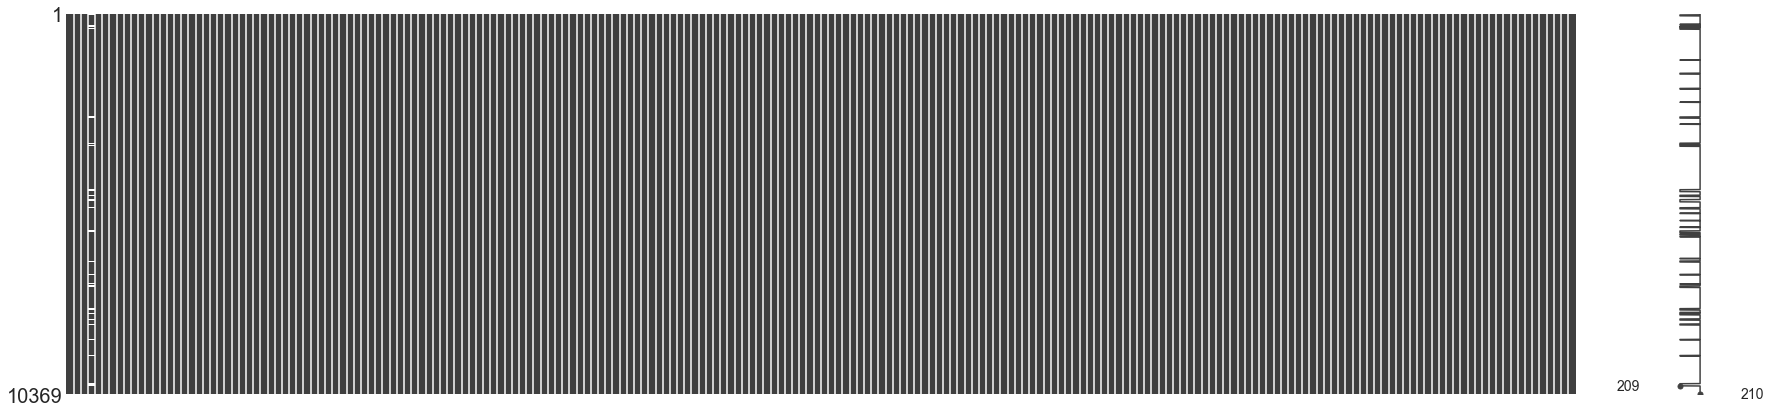

In [117]:
# Plot visualisation of the missing values for each feature of the raw DataFrame, df_opta_mbm_raw
msno.matrix(df_opta_mbm_raw, figsize = (30, 7))

In [118]:
# Counts of missing values
opta_null_value_stats = df_opta_mbm_raw.isnull().sum(axis=0)
opta_null_value_stats[opta_null_value_stats != 0]

Player Forename    863
dtype: int64

The visualisation shows us that the only field with missing values is the `Player Forename` attribute. This is something that will be fixed in the Data Engineering section.

### <a id='#section3.2'>3.2. F24 Event Data</a>
See: https://fcpython.com/blog/parsing-opta-f24-files-introduction-xml-python and https://github.com/imrankhan17/Parsing-Opta-files/blob/master/Parsing%20Opta%20F24%20files.ipynb

#### <a id='#section3.2.1'>3.2.1. Data Dictionary</a>
The [Opta](https://www.optasports.com/) dataset has one hundred and fourteen features (columns) with the following definitions and data types:

|   id | name                         | 1                                                                                                                               | 0                                                                                                                             |
|-----:|:-----------------------------|:--------------------------------------------------------------------------------------------------------------------------------|:------------------------------------------------------------------------------------------------------------------------------|
|    1 | `Pass`                         | a successful pass ie the pass accurately made it from one player to another without any interception                            | an unsuccessful pass ie the pass is wayward and does not make it to the other player or is intercepted                        |
|    2 | `Offside Pass`                | nan                                                                                                                             | nan                                                                                                                           |
|    3 | `Take On`                   | a player successfully dribbling the ball past the opponent and retaining possession afterwards                                  | a player attempting to dribble past an opposing but being unsuccessful eg tackled or losing possession                        |
|    4 | `Free kick`                  | the player who was fouled ie the player who 'won' the foul                                                                      | the player who committed the foul                                                                                             |
|    5 | `Out`                      | the team that gains possession by virtue of the opposite team putting the ball out of play                                      | the team & player that gave away possession of the ball by being the last player to touch the ball before it went out of play |
|    6 | `Corner `                      | the team that wins the corner by virtue of the opposite team putting the ball out of play                                       | the team & player that gave away possession of the ball by being the last player to touch the ball before it went out of play |
|    7 | `Tackle`                       | the tackling player both winning the tackle and then retaining possession of the ball afterwards (or the ball goes out of play) | the tackling player winning the tackle but not gaining possession of the ball                                                 |
|    8 | `Interception`                 | nan                                                                                                                             | nan                                                                                                                           |
|    9 | `Turnover`                     | nan                                                                                                                             | nan                                                                                                                           |
|   10 | `Save`                         | a successful save ie the shot was prevented from going into the goal                                                            | an unsuccessful save ie the shot led to a goal                                                                                |
|   11 | `Claim`                        | a successful catch by the goalkeeper                                                                                            | an unsuccessful catch ie the ball was dropped or fumbled                                                                      |
|   12 | `Clearance`                    | a clearance resulting in the team keeping possession of the ball                                                                | a clearance where the team lose possession of the ball                                                                        |
|   13 | `Miss`                         | nan                                                                                                                             | nan                                                                                                                           |
|   14 | `Post`                         | nan                                                                                                                             | nan                                                                                                                           |
|   15 | `Attempt Saved`                | nan                                                                                                                             | nan                                                                                                                           |
|   16 | `Goal`                         | nan                                                                                                                             | nan                                                                                                                           |
|   17 | `Card`                         | nan                                                                                                                             | nan                                                                                                                           |
|   18 | `Player off`                   | nan                                                                                                                             | nan                                                                                                                           |
|   19 | `Player on`                    | nan                                                                                                                             | nan                                                                                                                           |
|   20 | `Player retired`               | nan                                                                                                                             | nan                                                                                                                           |
|   21 | `Player returns`               | nan                                                                                                                             | nan                                                                                                                           |
|   22 | `Player becomes goalkeeper`    | nan                                                                                                                             | nan                                                                                                                           |
|   23 | `Goalkeeper becomes player`    | nan                                                                                                                             | nan                                                                                                                           |
|   24 | `Condition change`             | nan                                                                                                                             | nan                                                                                                                           |
|   25 | `Official change`              | nan                                                                                                                             | nan                                                                                                                           |
|   26 | `Possession`                   | nan                                                                                                                             | nan                                                                                                                           |
|   27 | `Start delay`                  | nan                                                                                                                             | nan                                                                                                                           |
|   28 | `End delay`                    | nan                                                                                                                             | nan                                                                                                                           |
|   29 | `Temporary stop`               | nan                                                                                                                             | nan                                                                                                                           |
|   30 | `End`                          | nan                                                                                                                             | nan                                                                                                                           |
|   31 | `Picked an orange`             | nan                                                                                                                             | nan                                                                                                                           |
|   32 | `Start`                        | nan                                                                                                                             | nan                                                                                                                           |
|   33 | `Start/End canceling`          | nan                                                                                                                             | nan                                                                                                                           |
|   34 | `Team set up`                  | nan                                                                                                                             | nan                                                                                                                           |
|   35 | `Player changed position`      | nan                                                                                                                             | nan                                                                                                                           |
|   36 | `Player changed Jersey number` | nan                                                                                                                             | nan                                                                                                                           |
|   37 | `Collection End`               | nan                                                                                                                             | nan                                                                                                                           |
|   38 | `Temp_Goal`                    | nan                                                                                                                             | nan                                                                                                                           |
|   39 | `Temp_Attempt`                 | nan                                                                                                                             | nan                                                                                                                           |
|   40 | `Formation change`             | nan                                                                                                                             | nan                                                                                                                           |
|   41 | `Punch`                        | nan                                                                                                                             | nan                                                                                                                           |
|   42 | `Good skill`                   | nan                                                                                                                             | nan                                                                                                                           |
|   43 | `Deleted event`                | nan                                                                                                                             | nan                                                                                                                           |
|   44 | `Aerial`                       | the player who successfully won the duel ie gained possession from it                                                           | the player who lost the duel ie did not win possession of the ball                                                            |
|   45 | `Challenge`                    | nan                                                                                                                             | nan                                                                                                                           |
|   46 | `Postponed`                    | nan                                                                                                                             | nan                                                                                                                           |
|   47 | `Rescinded card`               | nan                                                                                                                             | nan                                                                                                                           |
|   48 | `Provisional lineup`           | nan                                                                                                                             | nan                                                                                                                           |
|   49 | `Ball recovery`                | nan                                                                                                                             | nan                                                                                                                           |
|   50 | `Dispossessed`                 | nan                                                                                                                             | nan                                                                                                                           |
|   52 | `Keeper pick-up`               | nan                                                                                                                             | nan                                                                                                                           |
|   53 | `Cross not claimed`            | nan                                                                                                                             | nan                                                                                                                           |
|   54 | `Smother`                      | nan                                                                                                                             | nan                                                                                                                           |
|   55 | `Offside provoked`             | nan                                                                                                                             | nan                                                                                                                           |
| 54 |   `51` | Error                        | nan                                                                                                                             | nan                                                                                                                           |
|   58 | `Shot faced`                  | nan                                                                                                                             | nan                                                                                                                           |
|   56 | `Shield ball oop`             | nan                                                                                                                             | nan                                                                                                                           |
|   57 | `Foul throw in`                | nan                                                                                                                             | nan                                                                                                                           |
|   59 | `Keeper Sweeper`               | nan                                                                                                                             | nan                                                                                                                           |
|   62 | `Event placeholder`            | nan                                                                                                                             | nan                                                                                                                           |
|   60 | `Chance Missed`                | the ball simply hit the player unintentionally                                                                                  | player unsuccessfully controlled the ball                                                                                     |
|   61 | `Ball touch`                   | the ball simply hit the player unintentionally                                                                                  | player unsuccessfully controlled the ball                                                                                     |
|   63 | `Temp_Save`                    | nan                                                                                                                             | nan                                                                                                                           |
|   64 | `Resume`                       | nan                                                                                                                             | nan                                                                                                                           |


For a full list of definitions, see the official documentation [[link](https://github.com/eddwebster/football_analytics/blob/master/documentation/opta/Event%20Definitions%20-%20MCFC%20analytics.pdf)].

#### <a id='#section3.2.2'>3.2.2. Import Data</a>

##### Method 1: Open CSV prepared in R
R code for managing the F24 dataset [[link](http://profpeppersassistant.blogspot.com/2012/09/r-code-for-managing-f24-dataset.html)].

In [10]:
# Method 1: Open CSV prepared in R
#df_opta_events_raw = pd.read_excel(data_dir_opta + '/raw/events/' + 'events.csv')

##### Method 2: Parse XML file in Python
See: https://fcpython.com/blog/parsing-opta-f24-files-introduction-xml-python

First import the XML file using the imported XML module.

The following two lines below will take an XML file and parse it into something that we could navigate just like we do with an object by using square brackets:

In [12]:
# Import XML file using XML module
tree = et.ElementTree(file=data_dir_opta + '/raw/events/' + 'Bolton_ManCityF24.xml')
gameFile = tree.getroot()

Next take a look at what information we are given about the game itself with the ‘.attrib’ method from the XML module imported earlier.

We get loads of information about the match in a dictionary, where the data is laid out with a key, then the value. For example, we can see the team names and also their Opta IDs.

In [14]:
gameFile[0].attrib

{'id': '360481',
 'away_team_id': '43',
 'away_team_name': 'Manchester City',
 'competition_id': '8',
 'competition_name': 'English Barclays Premier League',
 'game_date': '2011-08-21T16:00:00',
 'home_team_id': '30',
 'home_team_name': 'Bolton Wanderers',
 'matchday': '2',
 'period_1_start': '2011-08-21T16:00:38',
 'period_2_start': '2011-08-21T17:03:47',
 'season_id': '2011',
 'season_name': 'Season 2011/2012'}

Print the match details:

In [24]:
# Print a string with the two teams, using %s and the attrib to dynamically fill the string
print('{} vs {}'.format(gameFile[0].attrib['home_team_name'], gameFile[0].attrib['away_team_name']))

Bolton Wanderers vs Manchester City


Tthe structure of the file that the match events lie within the game details tags. The first event is the following:

In [25]:
gameFile[0][0].attrib

{'id': '301038339',
 'event_id': '1',
 'type_id': '34',
 'period_id': '16',
 'min': '0',
 'sec': '0',
 'team_id': '43',
 'outcome': '1',
 'x': '0.0',
 'y': '0.0',
 'timestamp': '2011-08-21T15:23:06.696',
 'last_modified': '2011-08-21T15:54:56'}

We can see that there are event keys like `min`, `sec`, `x` and `y` – these are quite easy to understand. 

The values, like `outcome`: 1 and `event_id`: 1, don’t really make much sense by themselves. This is particularly important when it comes to teams, as we only have their `id` and not their name. This is tidied up in the next steps.

The Opta XML uses lots of IDs rather than names that are detailed in the Opta documentation [link]()

In [27]:
# Import XLS file of aggregated performance data as a pandas DataFrame
df_opta_event_definitions = pd.read_excel(data_dir_opta + '/raw/' + 'Event Definitions - Excel file.xlsx')

In [35]:
# Display DataFrame
df_opta_event_definitions.head()

,id,name,1,0
0,1,Pass,a successful pass ie the pass accurately made ...,an unsuccessful pass ie the pass is wayward an...
1,2,Offside Pass,NaN,NaN
2,3,Take On,a player successfully dribbling the ball past ...,a player attempting to dribble past an opposin...
3,4,Free kick,the player who was fouled ie the player who 'w...,the player who committed the foul
4,5,Out,the team that gains possession by virtue of th...,the team & player that gave away possession of...


In [33]:
# Print DataFrame as Markdown
#print(df_opta_event_definitions.to_markdown())

The events contained qualifiers. Let’s again use square brackets to pull the first one out for the event above:

In [34]:
gameFile[0][0][0].attrib

{'id': '2028397186', 'qualifier_id': '130', 'value': '4'}

We are going to loop through each of the events that we have identified above and take the details that we want from each. These details will go into different lists for different data categories (player, team, success, etc.). We will then put these lists into a table which is then ready for analysis, plotting or exporting.

Firstly though, we'll make the team names come through to make this a bit more readible, while than the team ID. The events only carry the team ID, so let’s create a dictionary that will allow us to later swap the ID for the team name:

In [38]:
team_dict = {gameFile[0].attrib['home_team_id']: gameFile[0].attrib['home_team_name'],
            gameFile[0].attrib['away_team_id']: gameFile[0].attrib['away_team_name']}


print(team_dict)

{'30': 'Bolton Wanderers', '43': 'Manchester City'}


For this tutorial, we’re simply going to take the x/y locations of the pass origin and destination, the time of the pass, the team and whether or not it was successful.

There’s so much more that we could take, such as the players, the pass length or any other details that you spot in the XML. If you’d like to pull those out too, doing so will make a great extension to this tutorial!

We’re going to start by creating the empty lists for our data:

In [99]:
#Create empty lists for the 8 columns we're collecting data for
x_origin = []
y_origin = []
x_destination = []
y_destination = []
outcome = []
minute = []
half = []
team = []
event_id = []
qualifier_id = []
type_id = []
ids  = []

The main part of the tutorial sees us going event-by-event and adding our desired details only when the event is a pass. To do this, we will use a for loop on each event, and when the event is a pass (id = 1), we will append the correct attribute to our lists created above. Some of these details are hidden in the qualifiers, so we’ll also iterate over those to get the information needed there.

This tutorial probably isn’t the best place to go through the intricacies of the feed, so take a look at the docs if you’re interested.

Follow the code below with comments on each of the above steps:

In [100]:
gameFile[0][0].attrib

{'id': '301038339',
 'event_id': '1',
 'type_id': '34',
 'period_id': '16',
 'min': '0',
 'sec': '0',
 'team_id': '43',
 'outcome': '1',
 'x': '0.0',
 'y': '0.0',
 'timestamp': '2011-08-21T15:23:06.696',
 'last_modified': '2011-08-21T15:54:56'}

In [101]:
# Iterate through each game in our file - we only have one
for game in gameFile:
    
    # Iterate through each event
    for event in game:
        print(event.attrib.get("type_id"))

34
34
32
32
1
1
7
3
5
5
1
1
4
4
1
1
1
1
7
3
6
6
1
4
4
1
1
44
44
12
7
50
1
8
49
55
2
1
1
12
1
4
4
15
10
12
12
1
1
12
49
1
1
1
5
5
1
1
49
12
61
1
1
1
5
5
1
1
1
1
1
1
1
4
4
1
1
1
1
49
50
7
1
4
4
1
1
1
44
44
1
1
5
5
1
1
1
1
1
3
45
7
50
5
5
1
1
1
1
8
49
1
1
1
1
1
8
49
1
1
1
12
5
5
1
61
49
1
1
1
49
1
8
1
1
61
49
1
49
1
8
61
1
1
5
5
1
1
1
12
1
43
43
1
1
1
1
49
1
1
8
43
61
43
1
1
61
4
4
1
1
3
7
49
1
1
56
5
5
1
1
1
12
1
49
1
8
49
1
1
45
3
1
1
1
1
8
49
1
1
1
1
12
43
6
6
1
12
13
5
1
5
44
44
1
1
49
1
1
1
1
15
10
6
6
1
12
6
6
1
12
49
1
1
1
1
52
1
1
61
5
5
1
1
8
49
1
1
1
1
1
1
1
1
1
1
8
1
1
1
1
1
5
5
1
1
12
1
1
1
1
1
1
1
1
1
1
49
1
1
1
1
1
1
49
1
1
61
5
5
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
10
15
49
1
1
8
52
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
7
3
61
43
12
5
5
1
1
45
3
1
10
15
52
1
1
52
1
1
1
1
1
1
49
1
1
1
1
1
1
1
1
1
8
49
1
1
1
13
5
5
1
4
4
1
11
1
1
1
4
4
1
61
52
1
1
52
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
7
50
49
1
4
4
1
12
15
10
6
6
1
11
1
12
61
61
1
1
1
4
4
1
1
1
1
1
1
1
1
1
1
12
61
49
1
1
1
1
1
1
1

In [102]:
# Iterate through each game in our file - we only have one
for game in gameFile:
    
    # Iterate through each event
    for event in game:
        
        # To the correct list, append the correct attribute using attrib.get()
        ids.append(event.attrib.get("id"))
        event_id.append(event.attrib.get("event_id"))
        type_id.append(event.attrib.get("type_id"))
        x_origin.append(event.attrib.get("x"))
        y_origin.append(event.attrib.get("y"))
        outcome.append(event.attrib.get("outcome"))
        minute.append(event.attrib.get("min"))
        half.append(event.attrib.get("period_id"))
        team.append(team_dict[event.attrib.get("team_id")])

        # Iterate through each qualifier 
        for qualifier in event:
            qualifier_id.append(event.attrib.get("qualifier_id"))
            x_destination.append(qualifier.attrib.get("value"))
            y_destination.append(qualifier.attrib.get("value"))

            
            """
            # If the qualifier is relevant, append the information to the x or y destination lists
            if qualifier.attrib.get("qualifier_id") == "140":
                x_destination.append(qualifier.attrib.get("value"))
            if qualifier.attrib.get("qualifier_id") == "141":
                y_destination.append(qualifier.attrib.get("value"))
            """

In [88]:
"""
#Iterate through each game in our file - we only have one
for game in gameFile:
    
    #Iterate through each event
    for event in game:
        
        #If the event is a pass (ID = 1)
        if event.attrib.get("type_id") == '1':
            
            #To the correct list, append the correct attribute using attrib.get()
            x_origin.append(event.attrib.get("x"))
            y_origin.append(event.attrib.get("y"))
            outcome.append(event.attrib.get("outcome"))
            minute.append(event.attrib.get("min"))
            half.append(event.attrib.get("period_id"))
            team.append(team_dict[event.attrib.get("team_id")])
            
            #Iterate through each qualifier 
            for qualifier in event:
                
                #If the qualifier is relevant, append the information to the x or y destination lists
                if qualifier.attrib.get("qualifier_id") == "140":
                    x_destination.append(qualifier.attrib.get("value"))
                if qualifier.attrib.get("qualifier_id") == "141":
                    y_destination.append(qualifier.attrib.get("value"))
"""

'\n#Iterate through each game in our file - we only have one\nfor game in gameFile:\n    \n    #Iterate through each event\n    for event in game:\n        \n        #If the event is a pass (ID = 1)\n        if event.attrib.get("type_id") == \'1\':\n            \n            #To the correct list, append the correct attribute using attrib.get()\n            x_origin.append(event.attrib.get("x"))\n            y_origin.append(event.attrib.get("y"))\n            outcome.append(event.attrib.get("outcome"))\n            minute.append(event.attrib.get("min"))\n            half.append(event.attrib.get("period_id"))\n            team.append(team_dict[event.attrib.get("team_id")])\n            \n            #Iterate through each qualifier \n            for qualifier in event:\n                \n                #If the qualifier is relevant, append the information to the x or y destination lists\n                if qualifier.attrib.get("qualifier_id") == "140":\n                    x_destination.

If this has worked correctly, we should have 8 lists populated. Let’s check out the minutes list:

In [103]:
print("The minute list is " + str(len(minute)) + " long and the 43rd entry is " + minute[42])

The list is 1673 long and the 43rd entry is 2


In [109]:
print("The ID list is " + str(len(ids)) + " long and the 43rd entry is " + minute[42])

The ID list is 1673 long and the 43rd entry is 2


You can check out each list in more detail, but they should work just fine.

Our final task is to create a table for our data from our lists. To do this, we just need to create a list of our column headers, then assign the list to each one. We’ll then flip our table to make it long, rather than wide – just like you would want to see in a spreadsheet. Let’s take a look:

In [104]:
# Create a list of our 8 columns/lists
column_titles = ["ids", "event_id", "type_id", "team", "half", "min", "x_origin", "y_origin", "x_destination", "y_destination", "outcome", "qualifier_id"]
            
# Use pd.DataFrame to create our table, assign the data in the order of our columns and give it the column titles above
final_table = pd.DataFrame(data=[ids, event_id, type_id, team, half, minute, x_origin, y_origin, x_destination, y_destination, outcome, qualifier_id], index=column_titles)

# Transpose, or flip, the table. Otherwise, our table will run from left to right, rather than top to bottom
final_table = final_table.T

# Show us the top 5 rows of the table
final_table.head()

,ids,event_id,type_id,team,half,min,x_origin,y_origin,x_destination,y_destination,outcome,qualifier_id
0,301038339,1,34,Manchester City,16,0,0.0,0.0,4,4,1,None
1,1475524684,1,34,Bolton Wanderers,16,0,0.0,0.0,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1,None
2,2036897618,2,32,Bolton Wanderers,1,0,0.0,0.0,"25, 2, 13, 18, 4, 6, 42, 7, 10, 16, 21, 5, 11,...","25, 2, 13, 18, 4, 6, 42, 7, 10, 16, 21, 5, 11,...",1,None
3,336246484,2,32,Manchester City,1,0,0.0,0.0,17476,17476,1,None
4,1372839298,3,1,Manchester City,1,0,50.1,50.0,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 0, 0, 0,...","1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 0, 0, 0,...",1,None


In [108]:
final_table.shape

(6601, 12)

So this is great for passes, and the same logic would apply for shots, fouls or even all events at the same time – just expand on the above with the relevant IDs from the Opta docs. And analysts, if you’re still struggling to get it done, the emergency loan window is always open!

Now that we’ve taken a complex XML and parsed the passes into a table, there’s a number of things that we can do. We could put the table into a wider dataset, do some analysis of these passes, visualise straight away or just export our new table to a csv:

In [105]:
df_opta_events_only = df_opta_event_definitions.drop([1, 0], axis=1) 

In [106]:
df_opta_events_only

,id,name
0,1,Pass
1,2,Offside Pass
2,3,Take On
3,4,Free kick
4,5,Out
...,...,...
59,62,Event placeholder
60,60,Chance Missed
61,61,Ball touch
62,63,Temp_Save


In [107]:
final_table

,ids,event_id,type_id,team,half,min,x_origin,y_origin,x_destination,y_destination,outcome,qualifier_id
0,301038339,1,34,Manchester City,16,0,0.0,0.0,4,4,1,None
1,1475524684,1,34,Bolton Wanderers,16,0,0.0,0.0,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1,None
2,2036897618,2,32,Bolton Wanderers,1,0,0.0,0.0,"25, 2, 13, 18, 4, 6, 42, 7, 10, 16, 21, 5, 11,...","25, 2, 13, 18, 4, 6, 42, 7, 10, 16, 21, 5, 11,...",1,None
3,336246484,2,32,Manchester City,1,0,0.0,0.0,17476,17476,1,None
4,1372839298,3,1,Manchester City,1,0,50.1,50.0,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 0, 0, 0,...","1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 0, 0, 0,...",1,None
...,...,...,...,...,...,...,...,...,...,...,...,...
6596,None,None,None,None,None,None,None,None,None,None,None,None
6597,None,None,None,None,None,None,None,None,None,None,None,None
6598,None,None,None,None,None,None,None,None,None,None,None,None
6599,None,None,None,None,None,None,None,None,1,1,None,None


In [122]:
df_opta_events_only['id'] = df_opta_events_only['id'].to_string()

In [123]:
final_table.dtypes

ids              object
event_id         object
type_id          object
team             object
half             object
min              object
x_origin         object
y_origin         object
x_destination    object
y_destination    object
outcome          object
qualifier_id     object
dtype: object

In [124]:
df_opta_events_only.dtypes

id      object
name    object
dtype: object

In [125]:
# Join the Bio and Status DataFrames to form one, unified DataFrame
test = pd.merge(final_table, df_opta_events_only, left_on='event_id', right_on='id', how='left')

In [126]:
test

,ids,event_id,type_id,team,half,min,x_origin,y_origin,x_destination,y_destination,outcome,qualifier_id,id,name
0,301038339,1,34,Manchester City,16,0,0.0,0.0,4,4,1,None,NaN,NaN
1,1475524684,1,34,Bolton Wanderers,16,0,0.0,0.0,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1,None,NaN,NaN
2,2036897618,2,32,Bolton Wanderers,1,0,0.0,0.0,"25, 2, 13, 18, 4, 6, 42, 7, 10, 16, 21, 5, 11,...","25, 2, 13, 18, 4, 6, 42, 7, 10, 16, 21, 5, 11,...",1,None,NaN,NaN
3,336246484,2,32,Manchester City,1,0,0.0,0.0,17476,17476,1,None,NaN,NaN
4,1372839298,3,1,Manchester City,1,0,50.1,50.0,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 0, 0, 0,...","1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 0, 0, 0,...",1,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6596,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN
6597,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN
6598,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN
6599,None,None,None,None,None,None,None,None,1,1,None,None,NaN,NaN


In [127]:
df_opta_f24_raw = test

#### <a id='#section3.2.3'>3.2.3. Initial Data Handling</a>
Let's quality of the dataset by looking first and last rows in pandas using the [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) methods.

In [128]:
# Display the first 5 rows of the raw DataFrame, df_opta_f24_raw
df_opta_f24_raw.head()

,ids,event_id,type_id,team,half,min,x_origin,y_origin,x_destination,y_destination,outcome,qualifier_id,id,name
0,301038339,1,34,Manchester City,16,0,0.0,0.0,4,4,1,None,NaN,NaN
1,1475524684,1,34,Bolton Wanderers,16,0,0.0,0.0,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1,None,NaN,NaN
2,2036897618,2,32,Bolton Wanderers,1,0,0.0,0.0,"25, 2, 13, 18, 4, 6, 42, 7, 10, 16, 21, 5, 11,...","25, 2, 13, 18, 4, 6, 42, 7, 10, 16, 21, 5, 11,...",1,None,NaN,NaN
3,336246484,2,32,Manchester City,1,0,0.0,0.0,17476,17476,1,None,NaN,NaN
4,1372839298,3,1,Manchester City,1,0,50.1,50.0,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 0, 0, 0,...","1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 0, 0, 0,...",1,None,NaN,NaN


In [129]:
# Display the last 5 rows of the raw DataFrame, df_opta_f24_raw
df_opta_f24_raw.tail()

,ids,event_id,type_id,team,half,min,x_origin,y_origin,x_destination,y_destination,outcome,qualifier_id,id,name
6596,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN
6597,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN
6598,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN
6599,None,None,None,None,None,None,None,None,1,1,None,None,NaN,NaN
6600,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN


In [130]:
# Print the shape of the raw DataFrame, df_opta_f24_raw
print(df_opta_f24_raw.shape)

(6601, 14)


In [131]:
# Print the column names of the raw DataFrame, df_opta_f24_raw
print(df_opta_f24_raw.columns)

Index(['ids', 'event_id', 'type_id', 'team', 'half', 'min', 'x_origin',
       'y_origin', 'x_destination', 'y_destination', 'outcome', 'qualifier_id',
       'id', 'name'],
      dtype='object')


The dataset has two hundred and ten features (columns). Full details of these attributes can be found in the [Data Dictionary](section3.3.1).

In [132]:
# Data types of the features of the raw DataFrame, df_opta_f24_raw
df_opta_f24_raw.dtypes

ids              object
event_id         object
type_id          object
team             object
half             object
min              object
x_origin         object
y_origin         object
x_destination    object
y_destination    object
outcome          object
qualifier_id     object
id               object
name             object
dtype: object

All six of the columns have the object data type. Full details of these attributes and their data types can be found in the [Data Dictionary](section3.3.1).

In [133]:
# Info for the raw DataFrame, df_opta_f24_raw
df_opta_f24_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6601 entries, 0 to 6600
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ids            1673 non-null   object
 1   event_id       1673 non-null   object
 2   type_id        1673 non-null   object
 3   team           1673 non-null   object
 4   half           1673 non-null   object
 5   min            1673 non-null   object
 6   x_origin       1673 non-null   object
 7   y_origin       1673 non-null   object
 8   x_destination  5513 non-null   object
 9   y_destination  5513 non-null   object
 10  outcome        1673 non-null   object
 11  qualifier_id   0 non-null      object
 12  id             0 non-null      object
 13  name           0 non-null      object
dtypes: object(14)
memory usage: 773.6+ KB


In [134]:
# Description of the raw DataFrame, df_opta_f24_raw, showing some summary statistics for each numberical column in the DataFrame
df_opta_mbm_raw.describe()

,Player ID,Team Id,Opposition id,Position Id,Appearances,Time Played,Starts,Substitute On,Substitute Off,Goals,First Goal,Winning Goal,Shots On Target inc goals,Shots Off Target inc woodwork,Blocked Shots,Penalties Taken,Penalty Goals,Penalties Saved,Penalties Off Target,Penalties Not Scored,Direct Free-kick Goals,Direct Free-kick On Target,Direct Free-kick Off Target,Blocked Direct Free-kick,Goals from Inside Box,Shots On from Inside Box,Shots Off from Inside Box,Blocked Shots from Inside Box,Goals from Outside Box,Shots On Target Outside Box,Shots Off Target Outside Box,Blocked Shots Outside Box,Headed Goals,Headed Shots On Target,Headed Shots Off Target,Headed Blocked Shots,Left Foot Goals,Left Foot Shots On Target,Left Foot Shots Off Target,Left Foot Blocked Shots,Right Foot Goals,Right Foot Shots On Target,Right Foot Shots Off Target,Right Foot Blocked Shots,Other Goals,Other Shots On Target,Other Shots Off Target,Other Blocked Shots,Shots Cleared off Line,Shots Cleared off Line Inside Area,Shots Cleared off Line Outside Area,Goals Open Play,Goals from Corners,Goals from Throws,Goals from Direct Free Kick,Goals from Set Play,Goals from penalties,Attempts Open Play on target,Attempts from Corners on target,Attempts from Throws on target,Attempts from Direct Free Kick on target,Attempts from Set Play on target,Attempts from Penalties on target,Attempts Open Play off target,Attempts from Corners off target,Attempts from Throws off target,Attempts from Direct Free Kick off target,Attempts from Set Play off target,Attempts from Penalties off target,Goals as a substitute,Total Successful Passes All,Total Unsuccessful Passes All,Assists,Key Passes,Total Successful Passes Excl Crosses Corners,Total Unsuccessful Passes Excl Crosses Corners,Successful Passes Own Half,Unsuccessful Passes Own Half,Successful Passes Opposition Half,Unsuccessful Passes Opposition Half,Successful Passes Defensive third,Unsuccessful Passes Defensive third,Successful Passes Middle third,Unsuccessful Passes Middle third,Successful Passes Final third,Unsuccessful Passes Final third,Successful Short Passes,Unsuccessful Short Passes,Successful Long Passes,Unsuccessful Long Passes,Successful Flick-Ons,Unsuccessful Flick-Ons,Successful Crosses Corners,Unsuccessful Crosses Corners,Corners Taken incl short corners,Corners Conceded,Successful Corners into Box,Unsuccessful Corners into Box,Short Corners,Throw Ins to Own Player,Throw Ins to Opposition Player,Successful Dribbles,Unsuccessful Dribbles,Successful Crosses Corners Left,Unsuccessful Crosses Corners Left,Successful Crosses Left,Unsuccessful Crosses Left,Successful Corners Left,Unsuccessful Corners Left,Successful Crosses Corners Right,Unsuccessful Crosses Corners Right,Successful Crosses Right,Unsuccessful Crosses Right,Successful Corners Right,Unsuccessful Corners Right,Successful Long Balls,Unsuccessful Long Balls,Successful Lay-Offs,Unsuccessful Lay-Offs,Through Ball,Successful Crosses Corners in the air,Unsuccessful Crosses Corners in the air,Successful crosses in the air,Unsuccessful crosses in the air,Successful open play crosses,Unsuccessful open play crosses,Touches,Goal Assist Corner,Goal Assist Free Kick,Goal Assist Throw In,Goal Assist Goal Kick,Goal Assist Set Piece,Key Corner,Key Free Kick,Key Throw In,Key Goal Kick,Key Set Pieces,Duels won,Duels lost,Aerial Duels won,Aerial Duels lost,Ground Duels won,Ground Duels lost,Tackles Won,Tackles Lost,Last Man Tackle,Total Clearances,Headed Clearances,Other Clearances,Clearances Off the Line,Blocks,Interceptions,Recoveries,Total Fouls Conceded,Fouls Conceded exc handballs pens,Total Fouls Won,Fouls Won in Danger Area inc pens,Fouls Won not in danger area,Foul Won Penalty,Handballs Conceded,Penalties Conceded,Offsides,Yellow Cards,Red Cards,Goals Conceded,Goals Conceded Inside Box,Goals Conceded Outside Box,Saves Made,Saves Made from Inside Box,Saves Made from Outside Box,Saves from Penalty,Catches,Punches,Drops,Crosses not Claimed,GK Distribution,GK 

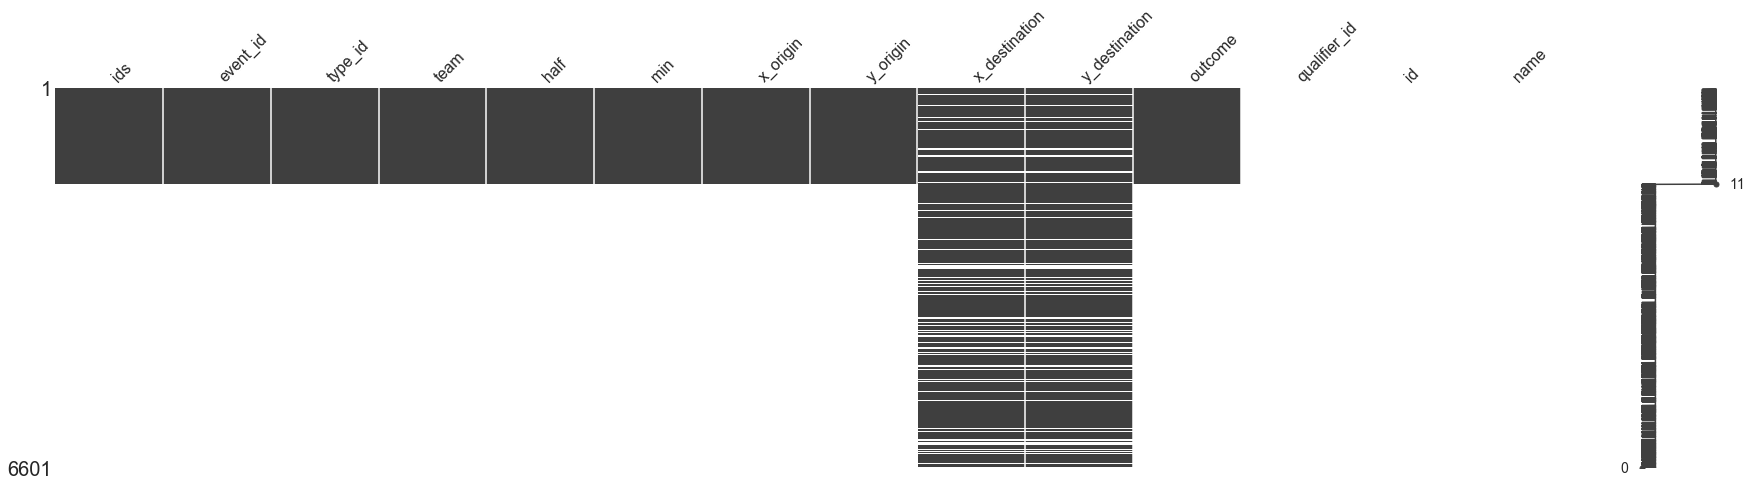

In [135]:
# Plot visualisation of the missing values for each feature of the raw DataFrame, df_opta_f24_raw
msno.matrix(df_opta_f24_raw, figsize = (30, 7))

In [136]:
# Counts of missing values
opta_null_value_stats = df_opta_f24_raw.isnull().sum(axis=0)
opta_null_value_stats[opta_null_value_stats != 0]

ids              4928
event_id         4928
type_id          4928
team             4928
half             4928
min              4928
x_origin         4928
y_origin         4928
x_destination    1088
y_destination    1088
outcome          4928
qualifier_id     6601
id               6601
name             6601
dtype: int64

The visualisation shows us that the only field with missing values is the `Player Forename` attribute. This is something that will be fixed in the Data Engineering section.

---

## <a id='#section4'>4. Data Engineering</a>

### <a id='#section4.1'>4.1. Introduction</a>
As per the Data Sources section, the Data Engineering section is divided into two sections for the aggregated match-by-match performance data and F24 Event data for Manchester City vs. Bolton Wanders (21/08/2011).

### <a id='#section4.2'>4.2. Aggregated Match-by-Match Performance Data</a>

#### <a id='#section4.2.1'>4.2.1. Assign Raw DataFrame to Engineered DataFrame</a>

In [194]:
# Assign Raw DataFrame to Engineered DataFrame
df_opta_mbm = df_opta_mbm_raw

#### <a id='#section4.2.2'>4.2.2. String Cleaning</a>

##### `Player Forename` and `Player Surname`
Some players such as 'Kolo Touré' have a null value for the `Player Forename` attribute. The foollowing cleans this code and derives a cleaned `Player Surname` and `Player Full Name` attribute.

In [195]:
# Clean names

## Forename
df_opta_mbm['Player Forename Cleaned'] = np.where(df_opta_mbm['Player Forename'].isnull(), df_opta_mbm['Player Surname'].str.split(' ').str[0], df_opta_mbm['Player Forename'])

## Surname
df_opta_mbm['Player Surname Cleaned'] = np.where(df_opta_mbm['Player Forename'].notnull(), df_opta_mbm['Player Surname'], df_opta_mbm['Player Surname'].str.split(' ').str[1])

## Create Full Name attribute from cleaned Forename and Surname attributes
df_opta_mbm['Player Full Name'] = df_opta_mbm['Player Forename Cleaned'] + ' ' + df_opta_mbm['Player Surname Cleaned']

In [193]:
# Test of 'Kolo Touré' - had a blank first name in the database
df_opta_mbm[df_opta_mbm['Player Surname'] == 'Kolo Touré']

,Date,Player ID,Player Surname,Player Forename,Team,Team Id,Opposition,Opposition id,Venue,Position Id,Appearances,Time Played,Starts,Substitute On,Substitute Off,Goals,First Goal,Winning Goal,Shots On Target inc goals,Shots Off Target inc woodwork,Blocked Shots,Penalties Taken,Penalty Goals,Penalties Saved,Penalties Off Target,Penalties Not Scored,Direct Free-kick Goals,Direct Free-kick On Target,Direct Free-kick Off Target,Blocked Direct Free-kick,Goals from Inside Box,Shots On from Inside Box,Shots Off from Inside Box,Blocked Shots from Inside Box,Goals from Outside Box,Shots On Target Outside Box,Shots Off Target Outside Box,Blocked Shots Outside Box,Headed Goals,Headed Shots On Target,Headed Shots Off Target,Headed Blocked Shots,Left Foot Goals,Left Foot Shots On Target,Left Foot Shots Off Target,Left Foot Blocked Shots,Right Foot Goals,Right Foot Shots On Target,Right Foot Shots Off Target,Right Foot Blocked Shots,Other Goals,Other Shots On Target,Other Shots Off Target,Other Blocked Shots,Shots Cleared off Line,Shots Cleared off Line Inside Area,Shots Cleared off Line Outside Area,Goals Open Play,Goals from Corners,Goals from Throws,Goals from Direct Free Kick,Goals from Set Play,Goals from penalties,Attempts Open Play on target,Attempts from Corners on target,Attempts from Throws on target,Attempts from Direct Free Kick on target,Attempts from Set Play on target,Attempts from Penalties on target,Attempts Open Play off target,Attempts from Corners off target,Attempts from Throws off target,Attempts from Direct Free Kick off target,Attempts from Set Play off target,Attempts from Penalties off target,Goals as a substitute,Total Successful Passes All,Total Unsuccessful Passes All,Assists,Key Passes,Total Successful Passes Excl Crosses Corners,Total Unsuccessful Passes Excl Crosses Corners,Successful Passes Own Half,Unsuccessful Passes Own Half,Successful Passes Opposition Half,Unsuccessful Passes Opposition Half,Successful Passes Defensive third,Unsuccessful Passes Defensive third,Successful Passes Middle third,Unsuccessful Passes Middle third,Successful Passes Final third,Unsuccessful Passes Final third,Successful Short Passes,Unsuccessful Short Passes,Successful Long Passes,Unsuccessful Long Passes,Successful Flick-Ons,Unsuccessful Flick-Ons,Successful Crosses Corners,Unsuccessful Crosses Corners,Corners Taken incl short corners,Corners Conceded,Successful Corners into Box,Unsuccessful Corners into Box,Short Corners,Throw Ins to Own Player,Throw Ins to Opposition Player,Successful Dribbles,Unsuccessful Dribbles,Successful Crosses Corners Left,Unsuccessful Crosses Corners Left,Successful Crosses Left,Unsuccessful Crosses Left,Successful Corners Left,Unsuccessful Corners Left,Successful Crosses Corners Right,Unsuccessful Crosses Corners Right,Successful Crosses Right,Unsuccessful Crosses Right,Successful Corners Right,Unsuccessful Corners Right,Successful Long Balls,Unsuccessful Long Balls,Successful Lay-Offs,Unsuccessful Lay-Offs,Through Ball,Successful Crosses Corners in the air,Unsuccessful Crosses Corners in the air,Successful crosses in the air,Unsuccessful crosses in the air,Successful open play crosses,Unsuccessful open play crosses,Touches,Goal Assist Corner,Goal Assist Free Kick,Goal Assist Throw In,Goal Assist Goal Kick,Goal Assist Set Piece,Key Corner,Key Free Kick,Key Throw In,Key Goal Kick,Key Set Pieces,Duels won,Duels lost,Aerial Duels won,Aerial Duels lost,Ground Duels won,Ground Duels lost,Tackles Won,Tackles Lost,Last Man Tackle,Total Clearances,Headed Clearances,Other Clearances,Clearances Off the Line,Blocks,Interceptions,Recoveries,Total Fouls Conceded,Fouls Conceded exc handballs pens,Total Fouls Won,Fouls Won in Danger Area inc pens,Fouls Won not in danger area,Foul Won Penalty,Handballs Conceded,Penalties Conceded,Offsides,Yellow Cards,Red Cards,Goals Conceded,Goals Conceded Inside Box,Goals Conceded Outside Box,Saves Made,Saves Made from Inside Box,Saves Made from Outside Box,Saves from Penalty,Cat

#### <a id='#section4.2.3'>4.2.3. Add `Season` attribute</a>

In [172]:
# Dictionary of competitions
dict_seasons = {
    2011: '11/12',
    2012: '12/13',
    2013: '13/14',
    2014: '14/15',
    2015: '15/16',
    2016: '16/17',
    2017: '17/18',
    2018: '18/19',
    2019: '19/20',
    2020: '20/21',
}

In [173]:
# Map grouped positions to DataFrame
df_opta_mbm['Season'] = df_opta_mbm['SeasId'].map(dict_seasons)

#### <a id='#section4.2.4'>4.2.4. Add `Competition` attribute from `CompId`</a>

In [174]:
# Dictionary of competitions
dict_comps = {
    8: 'Premier League',
    10: 'English Football League Championship',
    14: 'Scottish Premiership',
    11: 'English Football League 1',
    12: 'English Football League 2',
    1: 'FA Cup',
    2: 'English League Cup',
    7: 'English Football League Trophy',
    4: 'FIFA World Cup',
    5: 'Champions League',
    6: 'UEFA Europa League',
    20: 'J-League',
    21: 'Serie A',
    22: 'Bundesliga',
    22: 'La Liga'
}

In [175]:
# Map grouped positions to DataFrame
df_opta_mbm['Competitions'] = df_opta_mbm['CompId'].map(dict_comps)

#### <a id='#section4.2.5'>4.2.5. Add `Position Grouped` attribute from `Position Id`</a>

In [213]:
# Dictionary of competitions
dict_positions_grouped = {1: 'Goalkeeper',
                          2: 'Defender',
                          4: 'Midfielder',
                          6: 'Forward'
                         }

In [214]:
# Map grouped positions to DataFrame
df_opta_mbm['Position Grouped'] = df_opta_mbm['Position Id'].map(dict_positions_grouped)

#### <a id='#section4.2.6'>4.2.6. Export Data</a>

In [215]:
# Export DataFrame as a CSV file

## Export another copy to the Opta folder called 'latest' (can be overwritten)
df_opta_mbm.to_csv(data_dir_opta + '/engineered/' + 'opta_match_by_match_pl_1112.csv', index=None, header=True)

## Export another copy to the Opta folder called 'latest' (can be overwritten)
df_opta_mbm.to_csv(data_dir + '/export/opta_match_by_match_pl_1112.csv', index=None, header=True)

#### <a id='#section4.2.6'>4.2.6. Aggregate Data</a>

##### <a id='#section4.2.6.1'>4.2.6.1. Season Level</a>

In [201]:
df_opta_mbm.head()

,Date,Player ID,Player Surname,Player Forename,Team,Team Id,Opposition,Opposition id,Venue,Position Id,Appearances,Time Played,Starts,Substitute On,Substitute Off,Goals,First Goal,Winning Goal,Shots On Target inc goals,Shots Off Target inc woodwork,Blocked Shots,Penalties Taken,Penalty Goals,Penalties Saved,Penalties Off Target,Penalties Not Scored,Direct Free-kick Goals,Direct Free-kick On Target,Direct Free-kick Off Target,Blocked Direct Free-kick,Goals from Inside Box,Shots On from Inside Box,Shots Off from Inside Box,Blocked Shots from Inside Box,Goals from Outside Box,Shots On Target Outside Box,Shots Off Target Outside Box,Blocked Shots Outside Box,Headed Goals,Headed Shots On Target,Headed Shots Off Target,Headed Blocked Shots,Left Foot Goals,Left Foot Shots On Target,Left Foot Shots Off Target,Left Foot Blocked Shots,Right Foot Goals,Right Foot Shots On Target,Right Foot Shots Off Target,Right Foot Blocked Shots,Other Goals,Other Shots On Target,Other Shots Off Target,Other Blocked Shots,Shots Cleared off Line,Shots Cleared off Line Inside Area,Shots Cleared off Line Outside Area,Goals Open Play,Goals from Corners,Goals from Throws,Goals from Direct Free Kick,Goals from Set Play,Goals from penalties,Attempts Open Play on target,Attempts from Corners on target,Attempts from Throws on target,Attempts from Direct Free Kick on target,Attempts from Set Play on target,Attempts from Penalties on target,Attempts Open Play off target,Attempts from Corners off target,Attempts from Throws off target,Attempts from Direct Free Kick off target,Attempts from Set Play off target,Attempts from Penalties off target,Goals as a substitute,Total Successful Passes All,Total Unsuccessful Passes All,Assists,Key Passes,Total Successful Passes Excl Crosses Corners,Total Unsuccessful Passes Excl Crosses Corners,Successful Passes Own Half,Unsuccessful Passes Own Half,Successful Passes Opposition Half,Unsuccessful Passes Opposition Half,Successful Passes Defensive third,Unsuccessful Passes Defensive third,Successful Passes Middle third,Unsuccessful Passes Middle third,Successful Passes Final third,Unsuccessful Passes Final third,Successful Short Passes,Unsuccessful Short Passes,Successful Long Passes,Unsuccessful Long Passes,Successful Flick-Ons,Unsuccessful Flick-Ons,Successful Crosses Corners,Unsuccessful Crosses Corners,Corners Taken incl short corners,Corners Conceded,Successful Corners into Box,Unsuccessful Corners into Box,Short Corners,Throw Ins to Own Player,Throw Ins to Opposition Player,Successful Dribbles,Unsuccessful Dribbles,Successful Crosses Corners Left,Unsuccessful Crosses Corners Left,Successful Crosses Left,Unsuccessful Crosses Left,Successful Corners Left,Unsuccessful Corners Left,Successful Crosses Corners Right,Unsuccessful Crosses Corners Right,Successful Crosses Right,Unsuccessful Crosses Right,Successful Corners Right,Unsuccessful Corners Right,Successful Long Balls,Unsuccessful Long Balls,Successful Lay-Offs,Unsuccessful Lay-Offs,Through Ball,Successful Crosses Corners in the air,Unsuccessful Crosses Corners in the air,Successful crosses in the air,Unsuccessful crosses in the air,Successful open play crosses,Unsuccessful open play crosses,Touches,Goal Assist Corner,Goal Assist Free Kick,Goal Assist Throw In,Goal Assist Goal Kick,Goal Assist Set Piece,Key Corner,Key Free Kick,Key Throw In,Key Goal Kick,Key Set Pieces,Duels won,Duels lost,Aerial Duels won,Aerial Duels lost,Ground Duels won,Ground Duels lost,Tackles Won,Tackles Lost,Last Man Tackle,Total Clearances,Headed Clearances,Other Clearances,Clearances Off the Line,Blocks,Interceptions,Recoveries,Total Fouls Conceded,Fouls Conceded exc handballs pens,Total Fouls Won,Fouls Won in Danger Area inc pens,Fouls Won not in danger area,Foul Won Penalty,Handballs Conceded,Penalties Conceded,Offsides,Yellow Cards,Red Cards,Goals Conceded,Goals Conceded Inside Box,Goals Conceded Outside Box,Saves Made,Saves Made from Inside Box,Saves Made from Outside Box,Saves from Penalty,Cat

In [ ]:
# CODE HERE

##### <a id='#section4.2.6.2'>4.2.6.2. Team Level</a>

In [205]:
df_opta_team = df_opta_mbm

In [206]:
# Displays all one hundered and four columns
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_opta_team.dtypes)

Date                                              object
Player ID                                          int64
Player Surname                                    object
Player Forename                                   object
Team                                              object
Team Id                                            int64
Opposition                                        object
Opposition id                                      int64
Venue                                             object
Position Id                                        int64
Appearances                                        int64
Time Played                                        int64
Starts                                             int64
Substitute On                                      int64
Substitute Off                                     int64
Goals                                              int64
First Goal                                         int64
Winning Goal                   

In [207]:
df_opta_team = df_opta_team.drop(['Date',
                                  'Player ID',
                                  'Player Surname',
                                  'Player Forename',
                                  'Opposition',
                                  'Opposition id',
                                  'Venue',
                                  'Position Id',
                                  'Player Forename Cleaned',
                                  'Player Surname Cleaned',
                                  'Player Full Name'
                                 ], axis=1)

In [208]:
df_opta_team

,Team,Team Id,Appearances,Time Played,Starts,Substitute On,Substitute Off,Goals,First Goal,Winning Goal,Shots On Target inc goals,Shots Off Target inc woodwork,Blocked Shots,Penalties Taken,Penalty Goals,Penalties Saved,Penalties Off Target,Penalties Not Scored,Direct Free-kick Goals,Direct Free-kick On Target,Direct Free-kick Off Target,Blocked Direct Free-kick,Goals from Inside Box,Shots On from Inside Box,Shots Off from Inside Box,Blocked Shots from Inside Box,Goals from Outside Box,Shots On Target Outside Box,Shots Off Target Outside Box,Blocked Shots Outside Box,Headed Goals,Headed Shots On Target,Headed Shots Off Target,Headed Blocked Shots,Left Foot Goals,Left Foot Shots On Target,Left Foot Shots Off Target,Left Foot Blocked Shots,Right Foot Goals,Right Foot Shots On Target,Right Foot Shots Off Target,Right Foot Blocked Shots,Other Goals,Other Shots On Target,Other Shots Off Target,Other Blocked Shots,Shots Cleared off Line,Shots Cleared off Line Inside Area,Shots Cleared off Line Outside Area,Goals Open Play,Goals from Corners,Goals from Throws,Goals from Direct Free Kick,Goals from Set Play,Goals from penalties,Attempts Open Play on target,Attempts from Corners on target,Attempts from Throws on target,Attempts from Direct Free Kick on target,Attempts from Set Play on target,Attempts from Penalties on target,Attempts Open Play off target,Attempts from Corners off target,Attempts from Throws off target,Attempts from Direct Free Kick off target,Attempts from Set Play off target,Attempts from Penalties off target,Goals as a substitute,Total Successful Passes All,Total Unsuccessful Passes All,Assists,Key Passes,Total Successful Passes Excl Crosses Corners,Total Unsuccessful Passes Excl Crosses Corners,Successful Passes Own Half,Unsuccessful Passes Own Half,Successful Passes Opposition Half,Unsuccessful Passes Opposition Half,Successful Passes Defensive third,Unsuccessful Passes Defensive third,Successful Passes Middle third,Unsuccessful Passes Middle third,Successful Passes Final third,Unsuccessful Passes Final third,Successful Short Passes,Unsuccessful Short Passes,Successful Long Passes,Unsuccessful Long Passes,Successful Flick-Ons,Unsuccessful Flick-Ons,Successful Crosses Corners,Unsuccessful Crosses Corners,Corners Taken incl short corners,Corners Conceded,Successful Corners into Box,Unsuccessful Corners into Box,Short Corners,Throw Ins to Own Player,Throw Ins to Opposition Player,Successful Dribbles,Unsuccessful Dribbles,Successful Crosses Corners Left,Unsuccessful Crosses Corners Left,Successful Crosses Left,Unsuccessful Crosses Left,Successful Corners Left,Unsuccessful Corners Left,Successful Crosses Corners Right,Unsuccessful Crosses Corners Right,Successful Crosses Right,Unsuccessful Crosses Right,Successful Corners Right,Unsuccessful Corners Right,Successful Long Balls,Unsuccessful Long Balls,Successful Lay-Offs,Unsuccessful Lay-Offs,Through Ball,Successful Crosses Corners in the air,Unsuccessful Crosses Corners in the air,Successful crosses in the air,Unsuccessful crosses in the air,Successful open play crosses,Unsuccessful open play crosses,Touches,Goal Assist Corner,Goal Assist Free Kick,Goal Assist Throw In,Goal Assist Goal Kick,Goal Assist Set Piece,Key Corner,Key Free Kick,Key Throw In,Key Goal Kick,Key Set Pieces,Duels won,Duels lost,Aerial Duels won,Aerial Duels lost,Ground Duels won,Ground Duels lost,Tackles Won,Tackles Lost,Last Man Tackle,Total Clearances,Headed Clearances,Other Clearances,Clearances Off the Line,Blocks,Interceptions,Recoveries,Total Fouls Conceded,Fouls Conceded exc handballs pens,Total Fouls Won,Fouls Won in Danger Area inc pens,Fouls Won not in danger area,Foul Won Penalty,Handballs Conceded,Penalties Conceded,Offsides,Yellow Cards,Red Cards,Goals Conceded,Goals Conceded Inside Box,Goals Conceded Outside Box,Saves Made,Saves Made from Inside Box,Saves Made from Outside Box,Saves from Penalty,Catches,Punches,Drops,Crosses not Claimed,GK Distribution,GK Successful Distribution,GK Unsu

In [ ]:
df_opta_team = df_opta_team.groupby(['Team',
                                     'Team Id'
                                    ]
).agg(
    {
         'A': 'sum'    
    }
).reset_index()    # reset index to get grouped columns back

# Rename columns
df_opta_team.columns = ['A', 'B']

#### <a id='#section4.2.7'>4.2.7. Export DataFrame</a>
Export the engineered Events, Lineup, and Tactics [Opta](https://www.optasports.com/) DataFrames as CSV files.

### <a id='#section4.3'>4.3. F24 Event Data</a>

#### <a id='#section4.3.1'>4.3.1. Assign Raw DataFrame to Engineered DataFrame</a>

In [ ]:
# Assign Raw DataFrame to Engineered DataFrame
df_opta_f24 = df_opta_f24_raw

In [ ]:
# CODE HERE

### <a id='#section4.4'>4.4. Import Fixture Data</a>
https://datahub.io/sports-data/english-premier-league#resource-season-1112

In [148]:
# Import data as a DataFrame called 'df_original'. To use in wrangling process before creating 'df' DataFrame for analysis
df_pl_fixtures_1112 = pd.read_csv(data_dir_fixtures + '/Premier League/csv/season-1112.csv')

In [149]:
df_pl_fixtures_1112.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,BWH,BWD,BWA,GBH,GBD,GBA,IWH,IWD,IWA,LBH,LBD,LBA,SBH,SBD,SBA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,BSH,BSD,BSA,Bb1X2,BbMxH,BbAvH,BbMxD,BbAvD,BbMxA,BbAvA,BbOU,BbMx>2.5,BbAv>2.5,BbMx<2.5,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA
0,E0,13/08/11,Blackburn,Wolves,1,2,A,1,1,D,K Friend,16,13,8,4,14,10,12,6,4,2,0,0,2.20,3.20,3.5,2.00,3.30,3.60,2.10,3.20,3.5,2.0,3.3,3.3,2.00,3.40,3.75,2.0,3.25,3.40,2.20,3.10,3.50,2.05,3.40,3.60,2.15,3.4,3.60,2.00,3.40,3.60,37,2.22,2.13,3.43,3.29,3.75,3.52,37,2.06,1.96,1.89,1.82,18,-0.50,2.20,2.14,1.78,1.74
1,E0,13/08/11,Fulham,Aston Villa,0,0,D,0,0,D,L Mason,13,7,9,1,10,18,2,3,2,4,0,0,2.20,3.20,3.5,2.05,3.30,3.45,2.10,3.20,3.5,2.2,3.2,3.0,2.20,3.30,3.30,2.1,3.20,3.20,2.20,3.20,3.40,2.10,3.30,3.50,2.15,3.3,3.75,2.10,3.25,3.40,38,2.20,2.12,3.43,3.28,3.86,3.53,34,2.21,2.11,1.77,1.69,21,-0.25,1.83,1.80,2.14,2.08
2,E0,13/08/11,Liverpool,Sunderland,1,1,D,1,0,H,P Dowd,11,15,4,6,17,12,6,3,4,4,0,0,1.57,3.60,7.0,1.45,3.85,7.50,1.50,3.75,7.0,1.4,4.1,7.0,1.50,3.75,7.50,1.4,4.00,7.50,1.57,3.75,6.50,1.50,3.90,7.50,1.53,4.0,7.50,1.50,3.75,7.00,37,1.57,1.50,4.20,3.92,8.04,7.30,37,1.92,1.85,2.01,1.92,21,-1.00,1.92,1.88,2.02,1.98
3,E0,13/08/11,Newcastle,Arsenal,0,0,D,0,0,D,P Walton,6,9,1,4,9,11,2,5,3,5,0,1,3.75,3.25,2.1,3.65,3.25,2.00,3.75,3.20,2.0,3.7,3.3,1.9,3.75,3.40,2.00,3.4,3.40,1.95,3.75,3.20,2.05,4.00,3.50,1.91,3.80,3.4,2.10,3.75,3.25,2.05,36,4.00,3.68,3.52,3.35,2.15,2.05,34,1.89,1.80,2.10,1.98,20,0.50,1.84,1.79,2.16,2.10
4,E0,13/08/11,QPR,Bolton,0,4,A,0,1,A,M Atkinson,13,13,7,7,9,16,3,2,1,2,1,0,2.40,3.25,3.0,2.25,3.25,3.05,2.30,3.20,3.0,2.3,3.2,2.8,2.38,3.25,3.00,2.3,3.20,2.80,2.40,3.10,3.10,2.30,3.25,3.20,2.38,3.3,3.30,2.30,3.25,3.10,37,2.40,2.30,3.40,3.26,3.40,3.14,34,2.27,2.16,1.73,1.66,19,-0.25,2.00,1.95,1.98,1.92


In [ ]:
# CODE HERE

---

## <a id='#section5'>5. Summary</a>
This notebook engineers [Opta](https://www.optasports.com/) data using [pandas](http://pandas.pydata.org/).

---

## <a id='#section6'>6. Next Steps</a>
...

---

## <a id='#section7'>7. References</a>

#### Data
*    [Opta](https://www.optasports.com/) data

#### Matches
*    Manchester City vs. Bolton Wanders on 21/08/2011 [[link](https://www.bbc.co.uk/sport/football/14520274)]

#### MCFC Analytics
*    http://www.mcfc.co.uk/mcfcanalytics (now not online)
*    https://web.archive.org/web/20120821021930/http://www.mcfc.co.uk/Home/The%20Club/MCFC%20Analytics
*    https://web.archive.org/web/20120820000747/http://www.mcfc.co.uk/The-Club/MCFC-Analytics/What-is-MCFC-Analytics
*    https://web.archive.org/web/20120821051105/http://www.mcfc.co.uk/the-club/mcfc-analytics/who-is-the-data-for
*    https://www.theguardian.com/football/blog/2012/aug/16/manchester-city-player-statistics
*    https://thevideoanalyst.com/mcfc-analytics/
*    https://analysefootball.com/tag/mcfc-analytics/
*    https://www.soccermetrics.net/tag/mcfcanalytics
*    https://danjharrington.wordpress.com/tag/mcfc-analytics/
*    https://blog.bimeanalytics.com/english/bime-and-the-mcfc-analytics-project-with-opta
*    https://www.forbes.com/sites/zachslaton/2012/08/16/game-changer-mcfc-analytics-releases-full-season-of-opta-data-for-public-use/
*    https://public.tableau.com/profile/jburnmurdoch#!/vizhome/MCFCAnalyticsTierOne/MCFCpassing
*    https://www.sportingintelligence.com/2012/08/16/are-you-the-new-bill-james-mcfc-will-give-you-data-worth-thousands-to-find-out-160802/
*    http://www.soccerstatistically.com/blog/2012/9/17/dealing-with-the-mcfc-analytics-advanced-data-release.html
*    http://onfooty.com/2012/08/villarreal-2011-12-breaking-down-a-failed-season.html
*    http://analysefootball.com/2012/09/03/mcfc-analytics-summary-of-blog-posts-1-mcfcanalytics/
*    http://analysefootball.com/2012/09/10/mcfc-analytics-summary-of-blog-posts-2/
*    http://analysefootball.com/2012/08/30/passing-in-the-final-third-and-goals-epl-2011-12-mcfcanalytics/
*    http://public.tableausoftware.com/views/20120831_opta_metrics_summary/Dashboard1?:embed=y http://www.tips-for-excel.com/2012/08/how-do-your-football-team-pass-the-ball-mcfc-analytics/
*    http://thepowerofgoals.blogspot.co.uk/2012/09/how-teams-win-from-mcfc-data.html?m=1
*    http://thepowerofgoals.blogspot.co.uk/2012/08/how-fouls-turn-into-cards.html?m=1
*    https://efex.bimeapp.com/players/dashboard/MCFCStats
*    http://www.guardian.co.uk/news/datablog/interactive/2012/aug/21/premier-league-2011-12-performance-data-interactive
*    http://www.tips-for-excel.com/2012/08/what-englands-euro-2012-starting-11-should-really-have-been-according-to-data/
*    http://blog.analysismarketing.com/2012/09/mcfc-analytics-some-thoughts-about-data.html
*    http://rightbackbehindthegoal.blogspot.co.uk/2012/09/the-effectiveness-of-crossing-and.html?m=1
*    http://www.soccermetrics.net/soccer-database-development/mcfc-analytics-soccer-database-development/an-update-on-the-two-mcfc-analytics-projects

#### Parsing F24 Opta Data
*    https://github.com/imrankhan17/Parsing-Opta-files/blob/master/Parsing%20Opta%20F24%20files.ipynb
*    http://www.fcrstats.com/fcrstats_package.html
*    http://profpeppersassistant.blogspot.com/2012/09/r-code-for-managing-f24-dataset.html
*    https://github.com/FCrSTATS/OptaEventData

---

***Visit my website [EddWebster.com](https://www.eddwebster.com) or my [GitHub Repository](https://github.com/eddwebster) for more projects. If you'd like to get in contact, my Twitter handle is [@eddwebster](http://www.twitter.com/eddwebster) and my email is: edd.j.webster@gmail.com.***

[Back to the top](#top)